### set TabNet parameters

In [12]:
tabnet_params = dict(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    n_d = 16,
    n_a = 16,
    n_steps = 2,
    gamma = 2,
    n_independent = 2,
    n_shared = 2,
    lambda_sparse = 0,
    optimizer_fn = Adam,
    optimizer_params = dict(lr = (2e-2)),
    mask_type = "entmax",
    scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False),
    scheduler_fn = CosineAnnealingWarmRestarts,
    seed = 42,
    verbose = 10
    
)

### split folds and train 5 different models for each fold.

In [ ]:
seed_everything(42)

kfold = KFold(n_splits=5, random_state=42, shuffle=True)

oof_predictions = np.zeros((X.shape[0], 1))
test_predictions = np.zeros(X_test.shape[0])
feature_importances = pd.DataFrame()
feature_importances["feature"] = X.columns.tolist()
stats = pd.DataFrame()
explain_matrices = []
masks_ = []
fold_scores = []

for fold, (trn_ind, val_ind) in enumerate(kfold.split(X)):
    print(f"Training fold {fold + 1}")
    
    X_train, X_val = X.iloc[trn_ind].values, X.iloc[val_ind].values
    y_train, y_val = y.iloc[trn_ind].values.reshape(-1, 1), y.iloc[val_ind].values.reshape(-1, 1)

    clf = TabNetRegressor(**tabnet_params)
    
    clf.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        max_epochs=200,
        patience=50,
        batch_size=1024 * 20, 
        virtual_batch_size=128 * 20,
        num_workers=4,
        drop_last=False,
        eval_metric=[RMSPE],
        loss_fn=RMSPELoss
    )
    
    saved_filepath = clf.save_model(f"./fold{fold}")
    
    explain_matrix, masks = clf.explain(X_val)
    explain_matrices.append(explain_matrix)
    masks_.append(masks[0])
    masks_.append(masks[1])
    
    y_val_pred = clf.predict(X_val)
    oof_predictions[val_ind] = y_val_pred
    test_predictions += clf.predict(X_test.values).flatten() / 5
    
    feature_importances[f"importance_fold{fold + 1}"] = clf.feature_importances_
    stats[f"fold{fold + 1}_train_rmspe"] = clf.history['loss']
    stats[f"fold{fold + 1}_val_rmspe"] = clf.history['val_0_rmspe']
    
    y_val_true = y_val.flatten()
    y_val_pred = y_val_pred.flatten()
    
    fold_scores.append({
        "fold": fold + 1,
        "RMSPE": rmspe(y_val_true, y_val_pred),
        "RMSE": mean_squared_error(y_val_true, y_val_pred, squared=False),
        "MAE": mean_absolute_error(y_val_true, y_val_pred),
        "R2": r2_score(y_val_true, y_val_pred)
    })
    
    print(f"Fold {fold+1} - RMSPE: {fold_scores[-1]['RMSPE']:.6f}, RMSE: {fold_scores[-1]['RMSE']:.6f}, MAE: {fold_scores[-1]['MAE']:.6f}, R2: {fold_scores[-1]['R2']:.4f}")

print("\nFinal OOF Evaluation:")
print(f"RMSPE: {rmspe(y, oof_predictions.flatten()):.6f}")
print(f"RMSE : {mean_squared_error(y, oof_predictions.flatten(), squared=False):.6f}")
print(f"MAE  : {mean_absolute_error(y, oof_predictions.flatten()):.6f}")
print(f"R2   : {r2_score(y, oof_predictions.flatten()):.4f}")


Training fold 1
Device used : cuda
epoch 0  | loss: 305.64184| val_0_rmspe: 57.23746|  0:00:06s
epoch 10 | loss: 0.91579 | val_0_rmspe: 0.62269 |  0:01:02s
epoch 20 | loss: 0.28926 | val_0_rmspe: 0.2703  |  0:02:00s
epoch 30 | loss: 0.29178 | val_0_rmspe: 0.28758 |  0:02:59s
epoch 40 | loss: 0.25568 | val_0_rmspe: 0.27191 |  0:03:56s
epoch 50 | loss: 0.23586 | val_0_rmspe: 0.22847 |  0:04:54s
epoch 60 | loss: 0.22334 | val_0_rmspe: 0.22541 |  0:05:52s
epoch 70 | loss: 0.22316 | val_0_rmspe: 0.22319 |  0:06:51s
epoch 80 | loss: 0.21966 | val_0_rmspe: 0.21624 |  0:07:47s
epoch 90 | loss: 0.21838 | val_0_rmspe: 0.21593 |  0:08:45s
epoch 100| loss: 0.21477 | val_0_rmspe: 0.21299 |  0:09:44s
epoch 110| loss: 0.21228 | val_0_rmspe: 0.21125 |  0:10:41s
epoch 120| loss: 0.21122 | val_0_rmspe: 0.21255 |  0:11:38s
epoch 130| loss: 0.21081 | val_0_rmspe: 0.21219 |  0:12:36s
epoch 140| loss: 0.2092  | val_0_rmspe: 0.20969 |  0:13:35s
epoch 150| loss: 0.20869 | val_0_rmspe: 0.20788 |  0:14:30s
epoc

# Train RMSPE

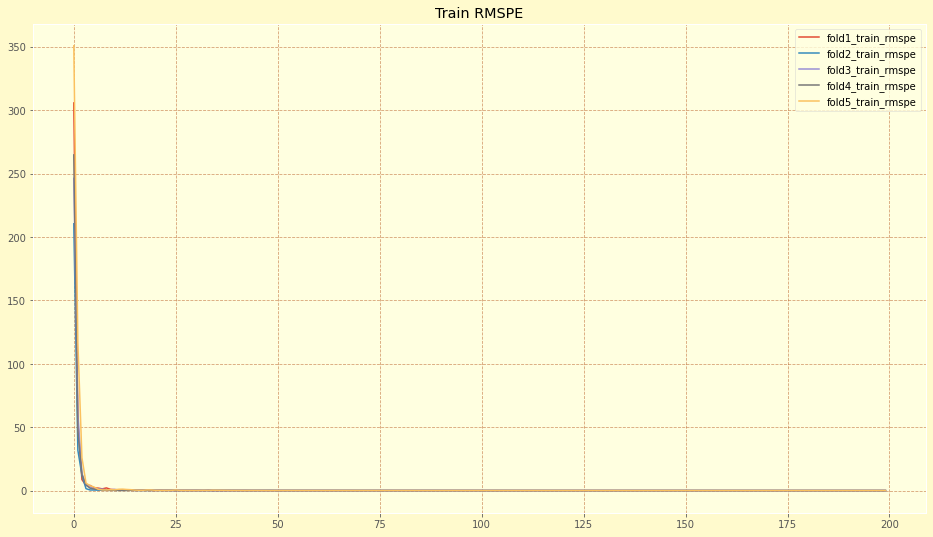

In [18]:
for i in stats.filter(like='train', axis=1).columns.tolist():
    plt.plot(stats[i], label=str(i))
plt.title('Train RMSPE')
plt.legend()  

# Val RMSPE

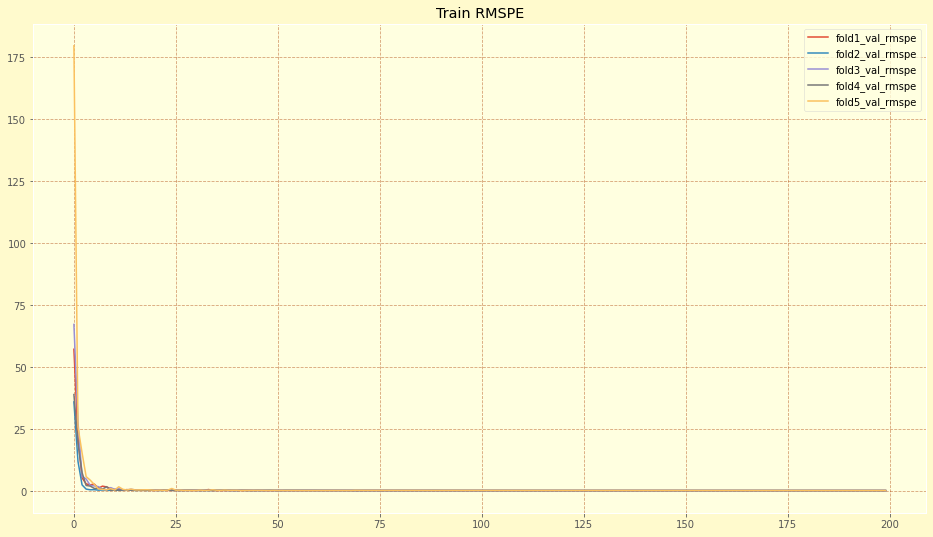

In [19]:
for i in stats.filter(like='val', axis=1).columns.tolist():
    plt.plot(stats[i], label=str(i))
plt.title('Train RMSPE')
plt.legend() 